# Data compression with IRCUR 

This notebook aims to compress dataset of video frames from a couple of scenes from "Hobbit" movies. Frames from same scene are roughly identical, so data should be low rank + sparse noise.

We use IRCUR to represent data in this form. There are 3 scenes, and we set rank to 8.

We used just 20 frames due to very low time to make this simulation (a couple of minutes on a laptop). 

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\januszs\\Projects\\robust-pca-master'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from robustpca.ircur import IRCUR

In [3]:
def ReadImageFromPath(path): #     # cv2.imread(path.as_posix())
    return cv2.imread(path)[:,:, 0] #take just first out of three pixel coordinates

In [4]:
def ImageToVector(image):
    #image is a 3d array
    return image.reshape((image.size,))

def VectorToImage(vector, image_shape):
    #vector is a reshaped 3d array that contained image of shape image_shape
    return vector.reshape(image_shape)

# LOAD DATA

In [5]:
DATASET_DIR_PATH = r"C:\Users\januszs\Projects\robust-pca-master\data\hobbit_dataset"
frames_paths = [os.path.join(DATASET_DIR_PATH, filename) for filename in
                os.listdir(DATASET_DIR_PATH)][:20]

In [6]:
chosen_frame = ReadImageFromPath(frames_paths[0])
frame_shape = chosen_frame.shape
frame_shape

(720, 1280)

In [7]:
frames_as_arrays = np.array([ReadImageFromPath(frame_path) for frame_path in frames_paths])

In [8]:
N = frames_as_arrays.shape[0]
N

20

In [9]:
m=4 #number of images shown for preview
m

4

In [10]:
np.random.seed(seed=1)
frames_to_show_ind = np.random.randint(low=0, high=N, size=m)
# frames_to_show_ind = np.array([939, 801, 325, 160], dtype='int') # hardcoding, seeds are deprecated
assert len(frames_to_show_ind) == m
frames_to_show_ind

array([ 5, 11, 12,  8])

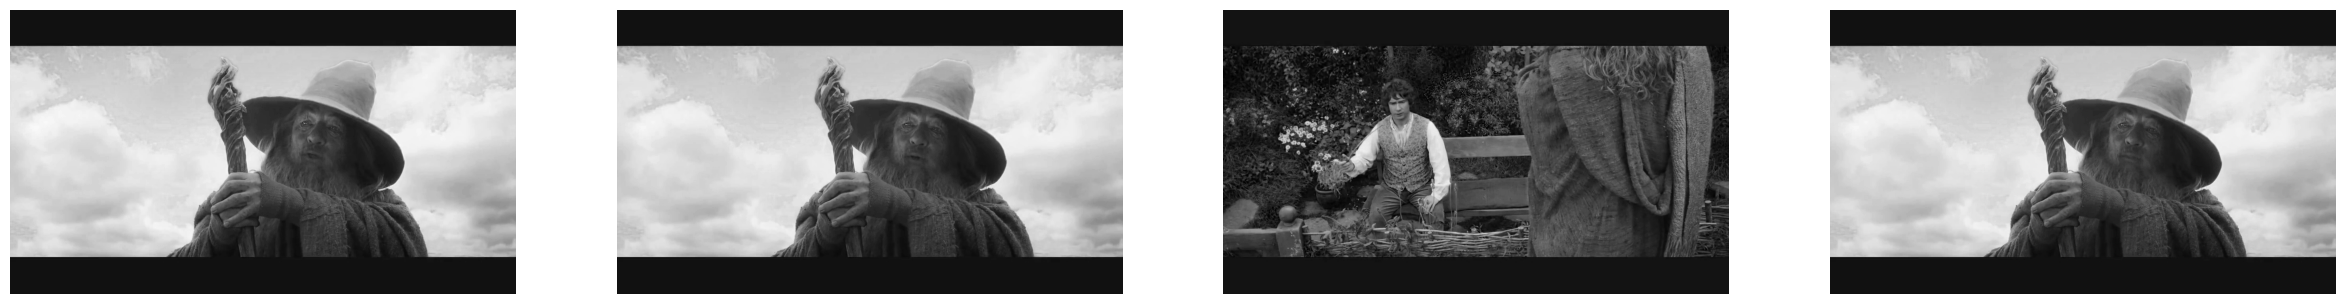

In [11]:
fig, axs = plt.subplots(1,4, figsize=(30,30))
for ax in axs:
    ax.axis('off')

for i,j in enumerate(frames_to_show_ind):
    axs[i].imshow(frames_as_arrays[j], cmap='gray') #showing as gray because we truncated colors

In [35]:
frames = np.array([ImageToVector(frame_as_array) for frame_as_array in frames_as_arrays])
original_rank = np.linalg.matrix_rank(frames)
original_rank

20

In [13]:
np.array(frames_paths)[frames_to_show_ind]; #comment semicolon to see filepaths of shown frames

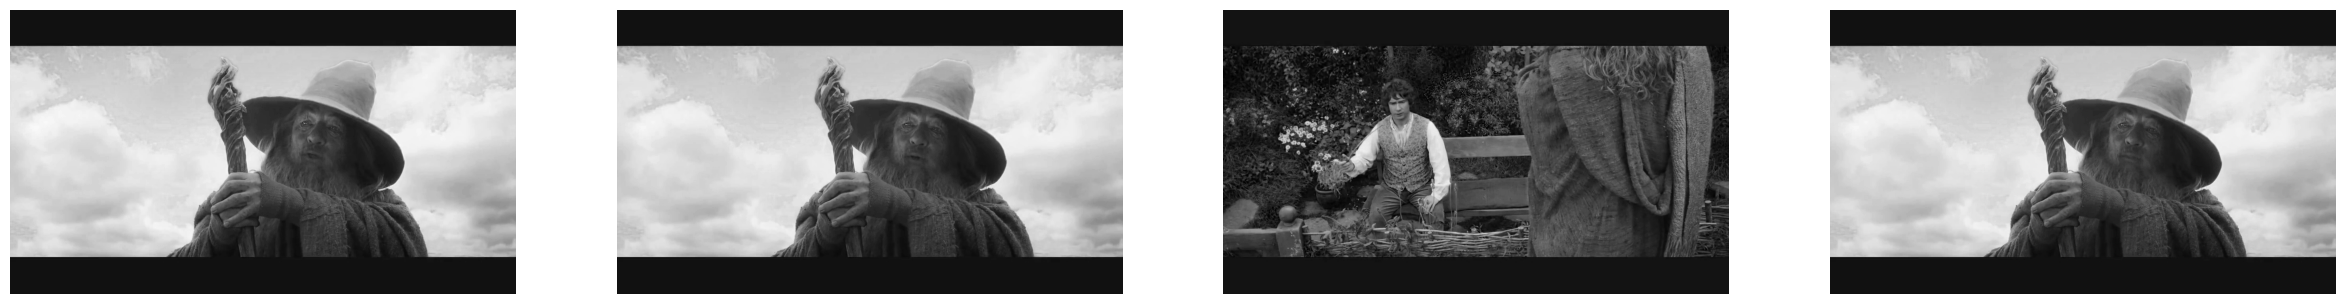

In [14]:
#should be the same as above
fig, axs = plt.subplots(1,4, figsize=(30,30))
for ax in axs:
    ax.axis('off')

for i,j in enumerate(frames_to_show_ind):
    axs[i].imshow(VectorToImage(frames[j], image_shape=frame_shape), cmap="gray")

# APPLY IRCUR

In [32]:
def my_stats(L, S, name, threshold):
    # some stats regarding how well compressed data D is with L and S
    # name is the name of this pair L,S (e.g. name of method that produced them, like PCP, IRCUR)
    L_rank = np.linalg.matrix_rank(L)
    original_nrow = S.shape[0]
    original_ncol = S.shape[1]
    L_relsize = L_rank * (L_rank + original_nrow + original_ncol)/(original_nrow * original_ncol)
    S_relsize = (np.abs(S) > threshold).mean()
    #
    stats_dict = {'name':name, "L_rank":L_rank,
                  #"original_nrow":original_nrow, "original_ncol":original_ncol,
                  "L_relsize":L_relsize, "S_relsize":S_relsize, "_threshold":threshold}
    return stats_dict

def my_stats_as_df(L, S, name, threshold):
    # returns: my_stats but as pd.DataFrame
    
    stats_dict = my_stats(L, S, name, threshold)
    for key, val in [(key,val) for (key,val) in stats_dict.items() if key!="name"]:
        stats_dict[key] = [val] # make val a one-element list (except if it holds the name)
    
    df = pd.DataFrame.from_dict(stats_dict).set_index('name')
    return df

In [16]:
pcp_alm = IRCUR()
rank = 8
c = 4
nrows, ncols = int(c * rank * np.log(frame_shape[0])), int(c * rank * np.log(frame_shape[1]))

In [17]:
L_ircur, S_ircur = pcp_alm.decompose(frames, rank, nrows, ncols,
                                     thresholding_decay=0.9, initial_threshold=100, verbose=True)

Iteration: 99, diff: 4.941211451857834e-06, terminating alg.
Elapsed: 212.55


In [34]:
my_stats_as_df(L_ircur, S_ircur, name="IRCUR", threshold=0.05).round(2)

,L_rank,L_relsize,S_relsize,_threshold
name,,,,
IRCUR,8,0.4,0.33,0.05


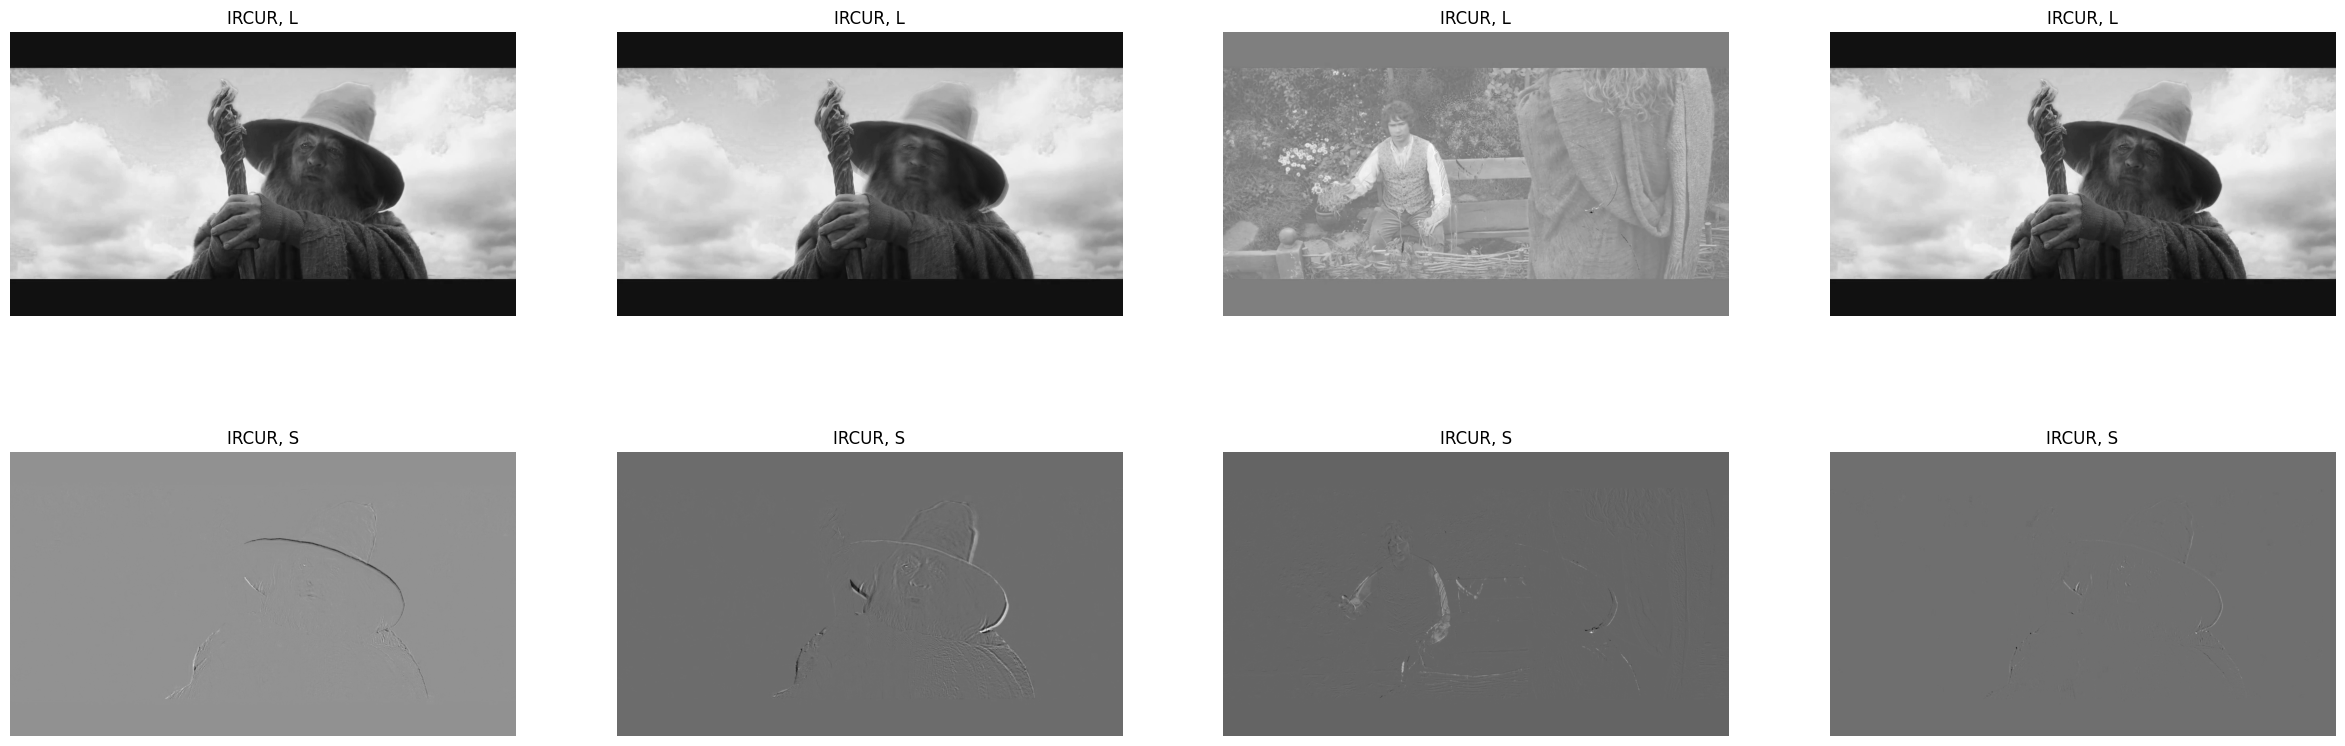

In [19]:
#should be the same as above
fig, axs = plt.subplots(2,4, figsize=(30,10))
for ax in axs.flatten():
    ax.axis('off')

for i,j in enumerate(frames_to_show_ind):
    axs[0][i].imshow(VectorToImage(L_ircur[j], image_shape=frame_shape), cmap="gray")
    axs[0][i].set_title("IRCUR, L")
    axs[1][i].imshow(VectorToImage(S_ircur[j], image_shape=frame_shape), cmap="gray")
    axs[1][i].set_title("IRCUR, S")

# Conclusion

Data was compressed to have roughly 33% non-negligible entries (with threshold 0.05).